A Deep Learning Toy Model for Image Compression
===

In this project, we will use simple deep learning networks for basic image compression.

You will get familiar with:

* train/test a simple deep learning model (for image compression in this project) with PyTorch library
* hyper-parameter tuning for deep learning model
* collect and analyse the training loss and metrics
* evaluate and visualize the result

## 1. Objectives
1. Train a baseline neural network.
2. Plot the loss-epoch curve.
3. Tune learning rate, the depth of the network, and different layers. Then compare the results in SSIM, PSNR.
4. Visualize some cases.
5. Customize your model (and loss, learning rate, scheduler, etc) for better performance.


## Get GPU ready

Change Runtime Type in the Colab menu to 'GPU'.

## Prepare the data

The data for training/test is at https://drive.google.com/drive/folders/1Ry2G14vY6uWoSG1rilvZOmNLvl3cOSUv?usp=sharing

1. Put this folder (and the data inside of course) in your GoogleDrive.
2. Run the command below to mount the GoogleDrive onto Colab.
3. Check the path to the data (e.g. `'/content/drive/MyDrive/MYDATA'`), and we will use this later.

Hint: you can check the file with either bash command or use the leftmost sidebar in Colab, there's a folder shaped icon.

**Note**: If you store the dataset in Google Drive, accessing the data might be slow due to Google Drive's limitations. Alternatively, you can upload the dataset to Colab's local runtime environment by clicking the '**Files**' button on the left sidebar. This approach can enhance data access speed during the session. However, please be aware that any data uploaded locally will be removed once you restart or exit the Colab session. To avoid data loss, consider reloading the data at the beginning of each session, or consistently use Google Drive mounting to manage your data.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Check the data: When you do `!ls YOUR_DATA_PATH`, you should see `train` and `valid` under the dir.

In [2]:
# cd drive/MyDrive/ELEC5306/
# !cd '/Users/harryk/Documents/usyd/2024sem1/ELEC5306/project2'

## 1.1 Code Template
But feel free to modify if you think it's needed.

Let's first import packages for this project. You are not required to make modifications to this. But if you are using any other packages that's not included, feel free to import anytime.

In [3]:
# ################################################
# import packages

import argparse
import math
import random
import shutil
import sys

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms


from pathlib import Path

from PIL import Image
from torch.utils.data import Dataset

import time

import matplotlib.pyplot as plt

import csv


Then we define a Dataset class that could iterate over images under a directory (`root/split`).

You are not required to make modifications to this.

In [4]:
import PIL
from pathlib import Path
import os
import PIL.Image
from torch.utils.data import Dataset

# ################################################
# define our Dataset class

class ImageFolder(Dataset):
    """Load an image folder database. Training and testing image samples
    are respectively stored in separate directories:

    .. code-block::

        - rootdir/
            - train/
                - img000.png
                - img001.png
                ...
            - valid/
                - img000.png
                - img001.png
                ...

    Args:
        root (string): root directory of the dataset
        transform (callable, optional): a function or transform that takes in a
            PIL image and returns a transformed version
        split (string): split mode ('train' or 'val')
    """

    def __init__(self, root, transform=None, split="train"):
        splitdir = Path(root) / split

        if not splitdir.is_dir():
            print(os.listdir(root))
            print(os.listdir(splitdir))
            raise RuntimeError(f'Invalid directory "{root}"')

        self.samples = [f for f in splitdir.iterdir() if f.is_file()]

        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            img: `PIL.Image.Image` or transformed `PIL.Image.Image`.
        """
        img = PIL.Image.open(self.samples[index]).convert("RGB")
        if self.transform:
            return self.transform(img)
        return img

    def __len__(self):
        return len(self.samples)


Then let's define a baseline neural network.

In [5]:
# ###################################################
# a baseline model

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self, N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            conv(N, N),
            conv(N, N),
            conv(N, M),
        )

        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            deconv(N, N),
            deconv(N, 3),
        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)

        return {
            "x_hat": x_hat,
        }

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1)
        return {"x_hat": x_hat}


Let's check if this network structure works fine with data flow.

In [6]:
# 1. get some random data
data = torch.zeros((1, 3, 128, 128))
# 2. get a random instance of the model class
model = Network(5, 5)
# 3. forward the data to the model
preds = model(data)
# 4. do compress
compressed = model.compress(data)
# 5. decompress
data_hat = model.decompress(compressed)

If there's no error pops out in the last code cell, then our network is fine.

We can compute the compression ratio of this network

In [7]:
print('compression ratio: compressed/original {}'.format(compressed.numel() / data.numel()))

compression ratio: compressed/original 0.006510416666666667


The compression ratio of this random network is suprising, but we don't expect any good performance as the model is too small.

Usually the larger the model, the better the performance given sufficient training data and iterations.

Let's move on to the loss, average meter, and optimizer.

A good thing about this task is we don't need extra label but the input image.

The loss is simply compared between the decoded image and the original one.

In [8]:
class Loss(nn.Module):

    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        out = {}
        out["mse_loss"] = self.mse(output["x_hat"], target)
        out["loss"] = out["mse_loss"] * 255

        return out

In [9]:
class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def configure_optimizers(net, learning_rate):

    optimizer = optim.Adam(
        net.parameters(),
        lr=learning_rate,
    )

    return optimizer

In [11]:
def save_checkpoint(state, is_best, filename="checkpoint.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss.pth.tar")

After we almost got everything we need, we define a `train_one_epoch` function for training the model for one epoch.

In [12]:
def train_one_epoch(
    model, criterion, train_dataloader, optimizer, epoch, clip_max_norm
):
    model.train()
    device = next(model.parameters()).device

    for i, d in enumerate(train_dataloader):
        d = d.to(device)

        optimizer.zero_grad()

        out_net = model(d)

        out_criterion = criterion(out_net, d)
        out_criterion["loss"].backward()
        if clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        optimizer.step()

        if i % 10 == 0:
            print(
                f"Train epoch {epoch}: ["
                f"{i*len(d)}/{len(train_dataloader.dataset)}"
                f" ({100. * i / len(train_dataloader):.0f}%)]"
                f'\tLoss: {out_criterion["loss"].item():.3f} |'
                f'\tMSE loss: {out_criterion["mse_loss"].item():.3f}'
            )


Likewise we further define a `test_epoch` function for getting the error on a valid set.

This part of data is not used in the training process, and will only be used to check the performance and give us implications of the performance of the model on unseen data.

This function returns the average loss on the valid split data.

In [13]:
def test_epoch(epoch, test_dataloader, model, criterion):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    mse_loss = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            d_out = out_net['x_hat']
            out_criterion = criterion(out_net, d)

            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])

    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tLoss: {loss.avg:.3f} |"
        f"\tMSE loss: {mse_loss.avg:.3f}\n"
    )

    return loss.avg

Finally we define a main function, and complete the whole training/testing process.

At the start of this main function, we define some arguments that's useful for training.

Define some arguments useful for training/validation.

In [14]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = True                                       # save trained model
dataset = '/kaggle/input/imageset/'       # path to the root of the dataset Modify this if you change the path
checkpoint = ''                                   # load pretrained model
epochs = 10                                       # total training epochs
num_workers = 0                                  # multi-process for loading training data
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-4
batch_size = 16
test_batch_size = 16
N = 128
M = 192

In [15]:
torch.manual_seed(seed)
random.seed(seed)

train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size), transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = ImageFolder(dataset, split="train", transform=train_transforms)
test_dataset = ImageFolder(dataset, split="valid", transform=test_transforms)

device = "cuda" if cuda and torch.cuda.is_available() else "mps"
#0423log: device is False cause "torch.cuda.is_available()" is False
#log: install the fit cuda, cudnn. 

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda" if cuda and torch.cuda.is_available() else "mps")
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=(device == "cuda" if cuda and torch.cuda.is_available() else "mps")
)

net = Network(N, M)
net = net.to(device)
print("training on", device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")
start = time.time()
for epoch in range(last_epoch, epochs):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss = test_epoch(epoch, test_dataloader, net, criterion)
    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

    if save:
        save_checkpoint(
            {
                "epoch": epoch,
                "state_dict": net.state_dict(),
                "loss": loss,
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
            },
            is_best,
        )
print(f"finished training in {round(time.time()-start)} seconds")


training on cuda
Learning rate: 0.0001
Train epoch 0: [0/250 (0%)]	Loss: 4323.734 |	MSE loss: 16.956
Train epoch 0: [160/250 (62%)]	Loss: 169.631 |	MSE loss: 0.665
Test epoch 0: Average losses:	Loss: 93.085 |	MSE loss: 0.365

Learning rate: 0.0001
Train epoch 1: [0/250 (0%)]	Loss: 110.006 |	MSE loss: 0.431
Train epoch 1: [160/250 (62%)]	Loss: 43.786 |	MSE loss: 0.172
Test epoch 1: Average losses:	Loss: 47.882 |	MSE loss: 0.188

Learning rate: 0.0001
Train epoch 2: [0/250 (0%)]	Loss: 53.662 |	MSE loss: 0.210
Train epoch 2: [160/250 (62%)]	Loss: 63.760 |	MSE loss: 0.250
Test epoch 2: Average losses:	Loss: 33.965 |	MSE loss: 0.133

Learning rate: 0.0001
Train epoch 3: [0/250 (0%)]	Loss: 26.210 |	MSE loss: 0.103
Train epoch 3: [160/250 (62%)]	Loss: 25.717 |	MSE loss: 0.101
Test epoch 3: Average losses:	Loss: 23.994 |	MSE loss: 0.094

Learning rate: 0.0001
Train epoch 4: [0/250 (0%)]	Loss: 23.801 |	MSE loss: 0.093
Train epoch 4: [160/250 (62%)]	Loss: 18.683 |	MSE loss: 0.073
Test epoch 4: A

Text(0.5, 1.0, 'compressed-decoded')

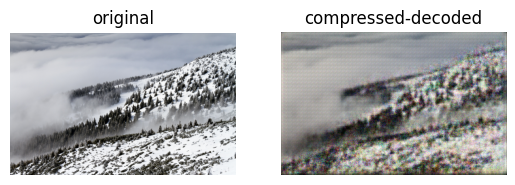

In [ ]:
# visualization
import matplotlib.pyplot as plt

dataset = '/kaggle/input/imageset' # Modify this if you change the path
test_dataset = ImageFolder(dataset, split="valid", transform=transforms.ToTensor())
image = test_dataset[1].unsqueeze(0).to(device)
net.load_state_dict(torch.load('checkpoint_best_loss.pth.tar', map_location=device)["state_dict"])
predicted = net(image)['x_hat'].squeeze(0).detach()

fig, axes = plt.subplots(1,2)
axes[0].imshow(image.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')

## 1.2 PSNR as AverageMeter for testing


A scratch example of PSNR, no guarantee of working.

Free to grab online.




In [21]:
def PSNR(img1, img2):
    # img1 and img2 within range [0, 1]
    img1, img2 = img1.detach(), img2.detach()
    img1 = img1 * 255
    img2 = img2 * 255
    batch_size = img1.shape[0]
    img1 = img1.reshape(batch_size, -1)
    img2 = img2.reshape(batch_size, -1)
    mse = torch.mean((img1 - img2) ** 2)
    return torch.mean(20 * torch.log10(255.0 / torch.sqrt(mse)))


A scratch example of SSIM, details are at https://github.com/VainF/pytorch-msssim

In [22]:
!pip install pytorch-msssim

In [23]:
import torch
from pytorch_msssim import ssim

# X: (N,3,H,W) a batch of non-negative RGB images (0~1)
# Y: (N,3,H,W)

X = torch.randn((2, 3, 10, 10))
Y = torch.randn((2, 3, 10, 10))

X = X * 255
Y = Y * 255

# calculate ssim & ms-ssim for each image
ssim_val = ssim(X, Y, data_range=255, size_average=False) # return (N,)
print(ssim_val)

tensor([0.0010, 0.0571])


/opt/conda/lib/python3.10/site-packages/pytorch_msssim/ssim.py:50: UserWarning: Skipping Gaussian Smoothing at dimension 2+0 for input: torch.Size([2, 3, 10, 10]) and win size: 11
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pytorch_msssim/ssim.py:50: UserWarning: Skipping Gaussian Smoothing at dimension 2+1 for input: torch.Size([2, 3, 10, 10]) and win size: 11
  warnings.warn(



Your code here:

In [24]:
def test_epoch(epoch, test_dataloader, model, criterion):
    '''
    Test the model for each epoch and evaluate its performance on a testing dataset.

    Parameters:
    - epoch (int): The current epoch number.
    - test_dataloader (DataLoader): DataLoader for the testing dataset.
    - model (torch.nn.Module): The neural network model to be tested.
    - criterion (function): The function used to compute the loss of the model.

    Returns:
    - float: The average loss of the model on the testing dataset for the current epoch.
    '''

    model.eval()  # Set the model to evaluation mode
    device = next(model.parameters()).device  # Get the device type used by the model's parameters

    # Initialize meters for tracking losses and metrics
    loss = AverageMeter()       # Track total loss
    mse_loss = AverageMeter()   # Track mean squared error loss
    psnr = AverageMeter()       # Track peak signal-to-noise ratio
    ssim_avg = AverageMeter()   # Track structural similarity index

    with torch.no_grad():  # Disable gradient computation
        for d in test_dataloader:
            d = d.to(device)  # Move data to the appropriate device
            out_net = model(d)  # Forward pass of the model
            d_out = out_net['x_hat']  # Extract reconstructed data
            out_criterion = criterion(out_net, d)  # Compute losses

            # Update loss and metric trackers
            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])
            psnr.update(PSNR(d_out, d))  # Compute PSNR
            ssim_avg.update(ssim(d * 255, d_out * 255, data_range=255, size_average=True))  # Compute SSIM

    # Print the average losses and metrics for this epoch
    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tLoss: {loss.avg:.3f} |"
        f"\tMSE loss: {mse_loss.avg:.3f} |"
        f"\tPSNR: {psnr.avg:.3f} |"
        f"\tSSIM: {ssim_avg.avg:.3f}\n"
    )

    return loss.avg  # Return the average loss


# do the test on valid split
test_epoch(10, test_dataloader, net, criterion)


Test epoch 10: Average losses:	Loss: 6.483 |	MSE loss: 0.025 |	PSNR: 16.018 |	SSIM: 0.173



tensor(6.4826, device='cuda:0')

## 1.3 Loss-Epoch curve


A naive example, no guarantee of working.

In [25]:
# import matplotlib.pyplot as plt

loss_epoch = list()
start = time.time()
for epoch in range(last_epoch, epochs): # train the network again and record the loss
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss = test_epoch(epoch, test_dataloader, net, criterion)
    loss_epoch.append(loss) # record the loss
    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)


print(f"finished training in {round(time.time()-start)} seconds")


Learning rate: 0.0001
Train epoch 0: [0/250 (0%)]	Loss: 5.556 |	MSE loss: 0.022
Train epoch 0: [160/250 (62%)]	Loss: 6.793 |	MSE loss: 0.027
Test epoch 0: Average losses:	Loss: 5.613 |	MSE loss: 0.022 |	PSNR: 16.643 |	SSIM: 0.161

Learning rate: 0.0001
Train epoch 1: [0/250 (0%)]	Loss: 5.732 |	MSE loss: 0.022
Train epoch 1: [160/250 (62%)]	Loss: 3.701 |	MSE loss: 0.015
Test epoch 1: Average losses:	Loss: 4.849 |	MSE loss: 0.019 |	PSNR: 17.277 |	SSIM: 0.224

Learning rate: 0.0001
Train epoch 2: [0/250 (0%)]	Loss: 2.675 |	MSE loss: 0.010
Train epoch 2: [160/250 (62%)]	Loss: 3.934 |	MSE loss: 0.015
Test epoch 2: Average losses:	Loss: 4.231 |	MSE loss: 0.017 |	PSNR: 17.870 |	SSIM: 0.238

Learning rate: 0.0001
Train epoch 3: [0/250 (0%)]	Loss: 5.320 |	MSE loss: 0.021
Train epoch 3: [160/250 (62%)]	Loss: 2.827 |	MSE loss: 0.011
Test epoch 3: Average losses:	Loss: 4.818 |	MSE loss: 0.019 |	PSNR: 17.300 |	SSIM: 0.249

Learning rate: 0.0001
Train epoch 4: [0/250 (0%)]	Loss: 4.297 |	MSE loss: 0.

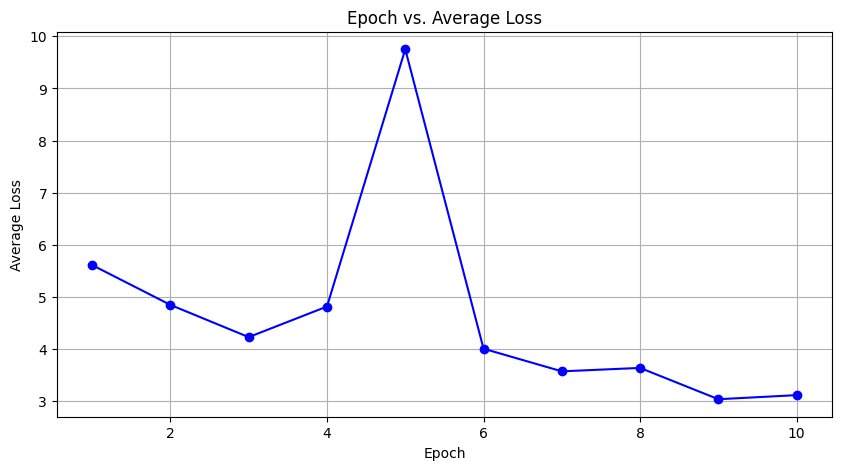

In [26]:
def plotloss(epochs, loss_epoch):
    '''
    Plot the average loss per epoch during training.

    Parameters:
    - epochs (int): The total number of epochs completed during training.
    - loss_epoch (list): A list containing the loss values for each epoch.

    This function creates a line plot with the epoch number on the x-axis and the average loss on the y-axis.
    And each point represents the average loss for a given epoch.
    '''

    xs = range(1, epochs + 1)  # Create a list of epoch numbers starting from 1 to 'epochs'
    ys = loss_epoch  # Loss values for each epoch
    y = []  # To store the loss values in a format suitable for plotting

    # Convert loss values from tensors to numpy arrays if necessary
    for i in ys:
        y.append(i.cpu().detach().numpy())  # Detach loss from the computation graph and convert to numpy

    # Plot configuration
    plt.figure(figsize=(10, 5))  # Set the size of the plot
    plt.plot(xs, y, marker='o', linestyle='-', color='b')  # Plot the loss values with markers
    plt.title('Epoch vs. Average Loss')  # Title of the plot
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.ylabel('Average Loss')  # Label for the y-axis
    plt.grid(True)  # Enable grid for better readability
    plt.show()  # Display the plot


plotloss(10,loss_epoch)


Your code here:

## 1.4 Tune hyper parameters and complete corresponding analysis

Model with 10 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 9: Average losses:	Loss: 3.440 |	MSE loss: 0.013 |	PSNR: 18.769 |	SSIM: 0.367



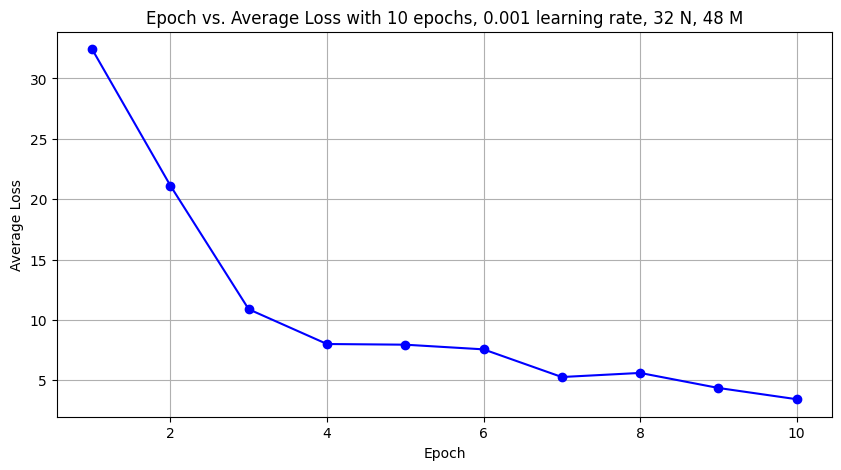

Model with 20 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 19: Average losses:	Loss: 2.090 |	MSE loss: 0.008 |	PSNR: 20.919 |	SSIM: 0.469



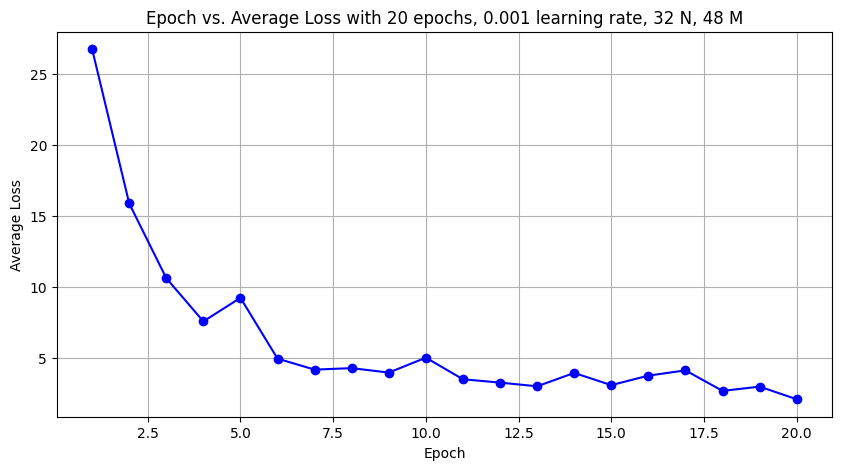

Model with 30 epochs, 0.001 learning rate, 32 N, 48 M Test epoch 29: Average losses:	Loss: 1.936 |	MSE loss: 0.008 |	PSNR: 21.247 |	SSIM: 0.551



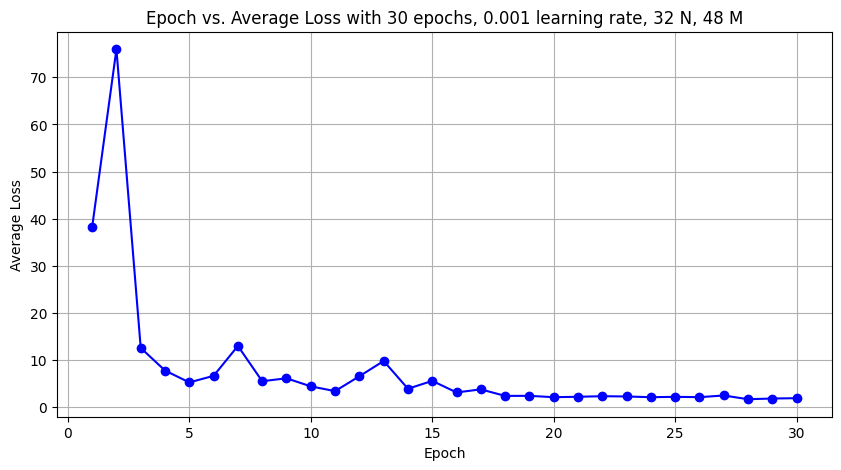

Model with 10 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 9: Average losses:	Loss: 9.623 |	MSE loss: 0.038 |	PSNR: 14.275 |	SSIM: 0.141



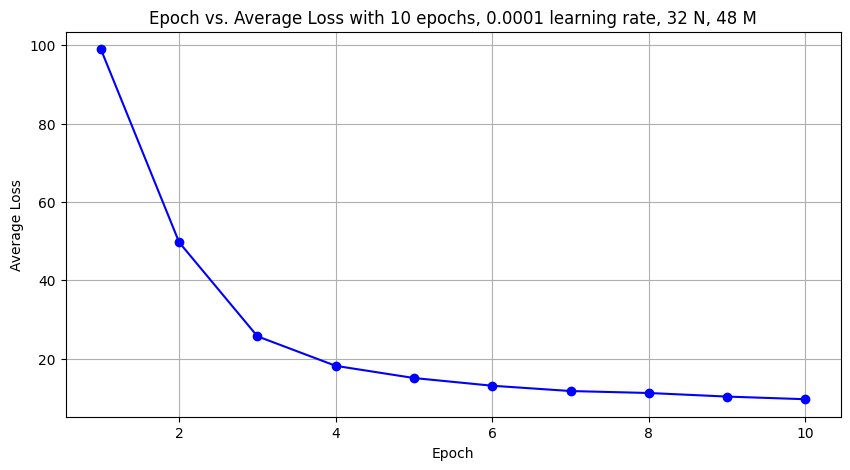

Model with 20 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 19: Average losses:	Loss: 5.196 |	MSE loss: 0.020 |	PSNR: 16.971 |	SSIM: 0.229



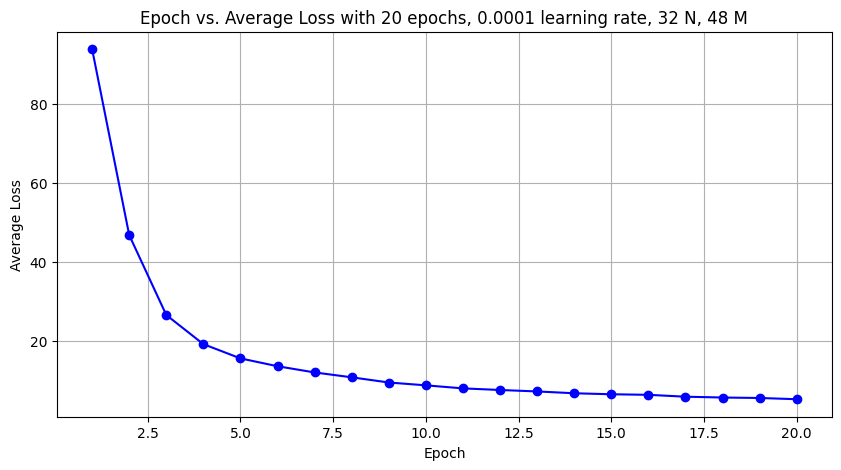

Model with 30 epochs, 0.0001 learning rate, 32 N, 48 M Test epoch 29: Average losses:	Loss: 4.116 |	MSE loss: 0.016 |	PSNR: 17.986 |	SSIM: 0.276



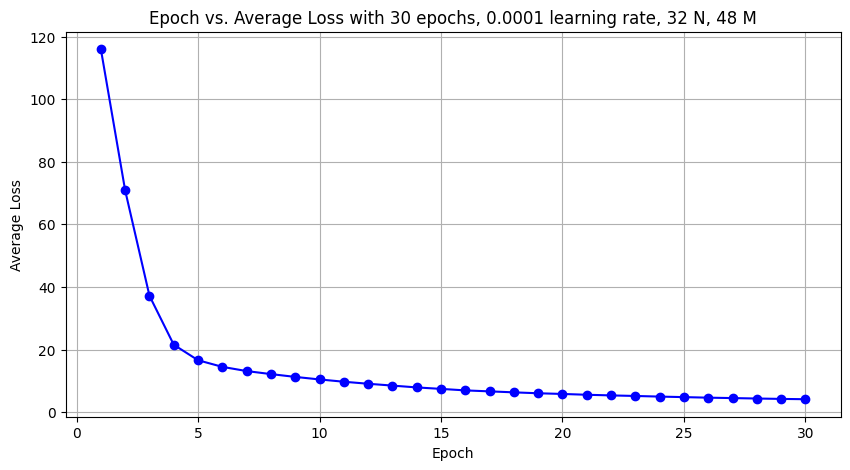

Model with 10 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 9: Average losses:	Loss: 71.391 |	MSE loss: 0.280 |	PSNR: 5.606 |	SSIM: 0.010



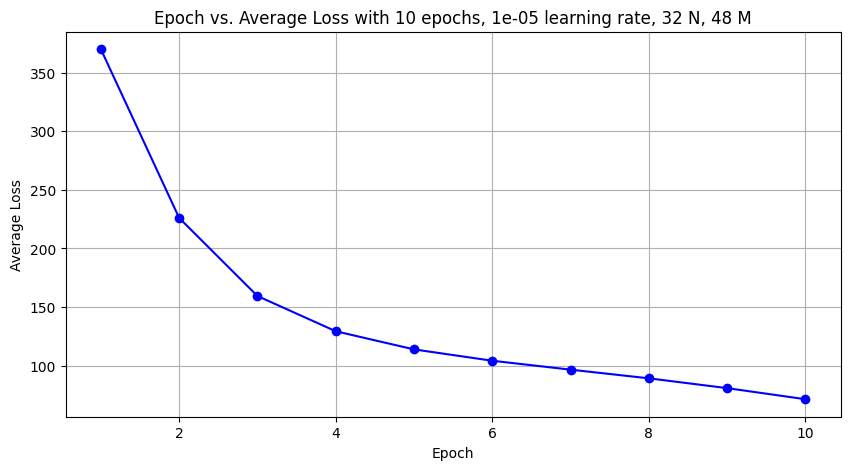

Model with 20 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 19: Average losses:	Loss: 28.597 |	MSE loss: 0.112 |	PSNR: 9.560 |	SSIM: 0.030



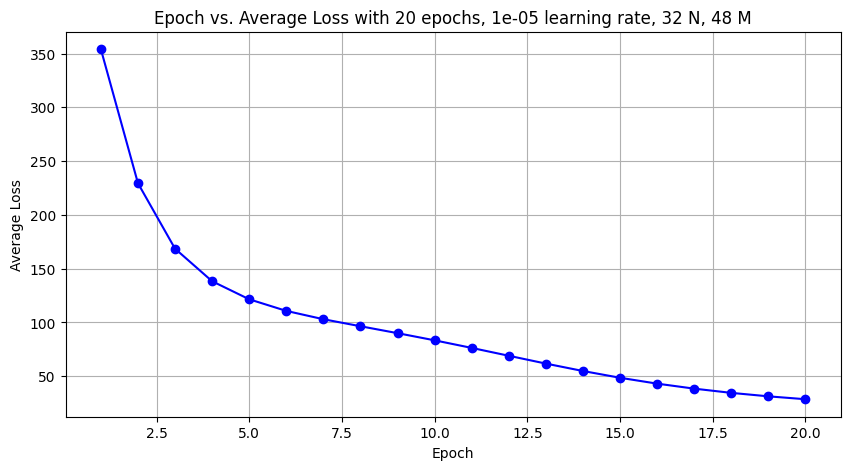

Model with 30 epochs, 1e-05 learning rate, 32 N, 48 M Test epoch 29: Average losses:	Loss: 18.807 |	MSE loss: 0.074 |	PSNR: 11.373 |	SSIM: 0.065



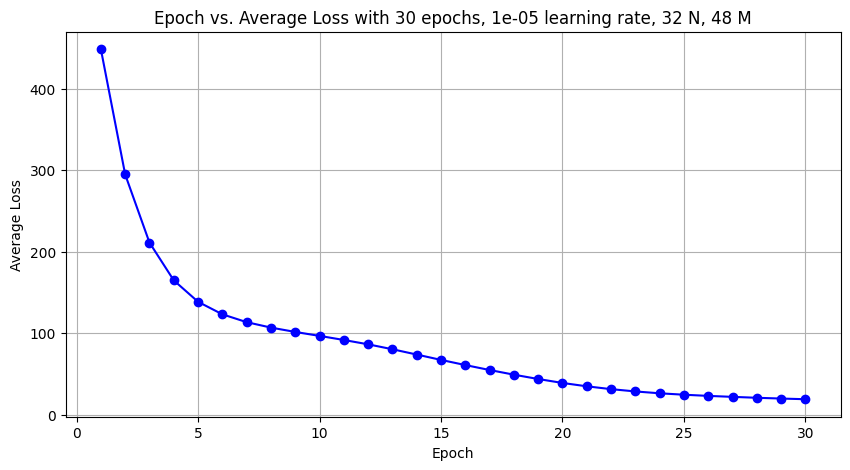

Model with 10 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 9: Average losses:	Loss: 5.047 |	MSE loss: 0.020 |	PSNR: 17.087 |	SSIM: 0.256



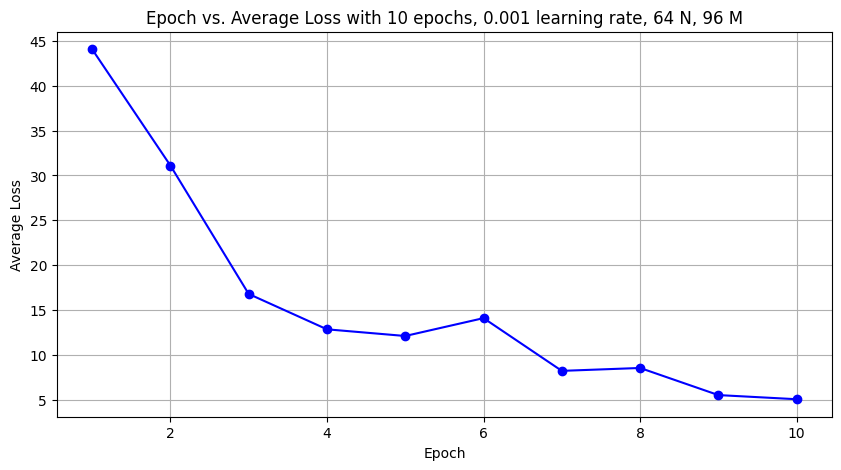

Model with 20 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 19: Average losses:	Loss: 2.725 |	MSE loss: 0.011 |	PSNR: 19.748 |	SSIM: 0.472



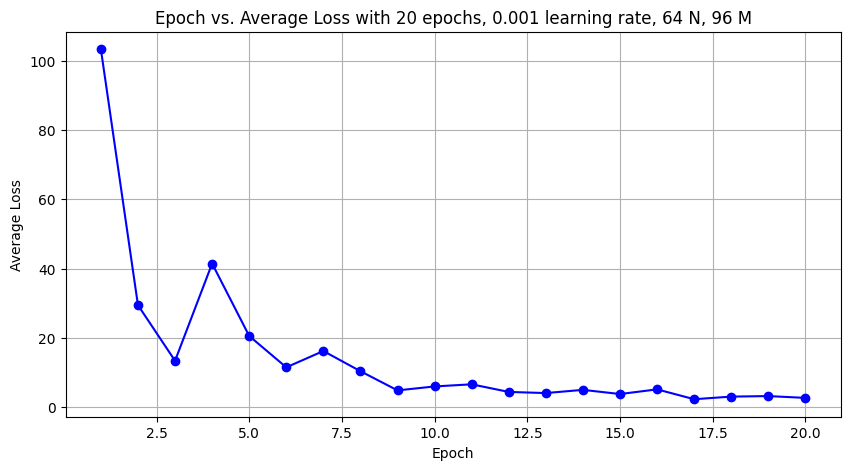

Model with 30 epochs, 0.001 learning rate, 64 N, 96 M Test epoch 29: Average losses:	Loss: 3.352 |	MSE loss: 0.013 |	PSNR: 18.909 |	SSIM: 0.590



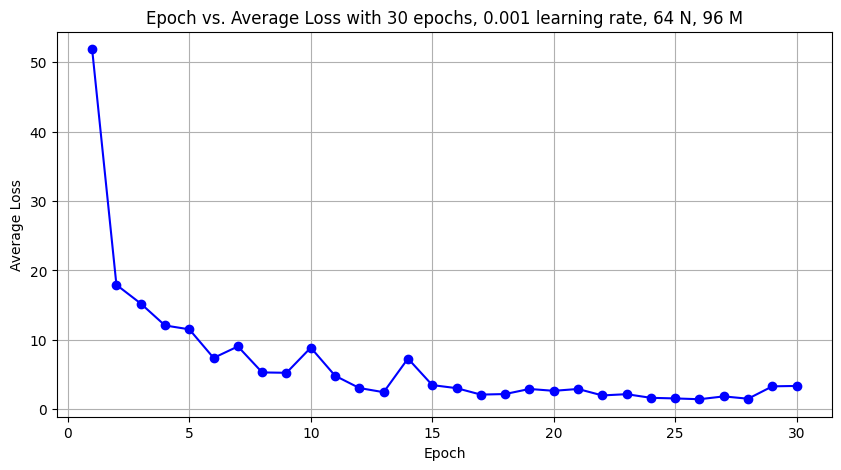

Model with 10 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 9: Average losses:	Loss: 9.263 |	MSE loss: 0.036 |	PSNR: 14.468 |	SSIM: 0.134



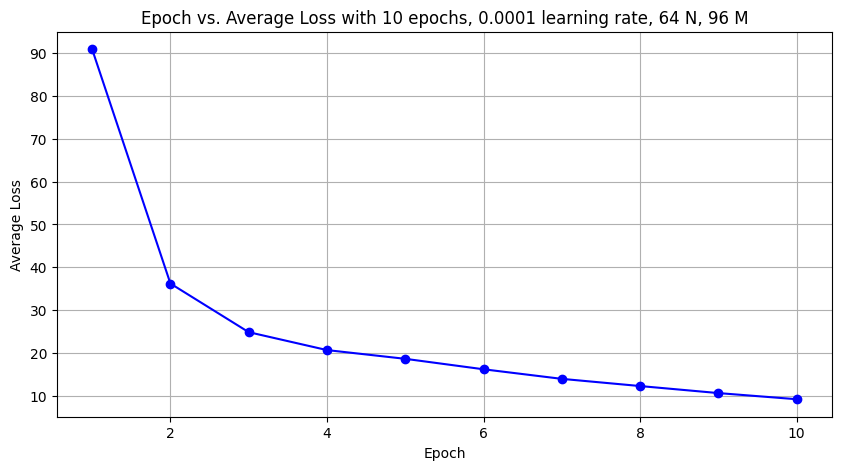

Model with 20 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 19: Average losses:	Loss: 3.399 |	MSE loss: 0.013 |	PSNR: 18.823 |	SSIM: 0.298



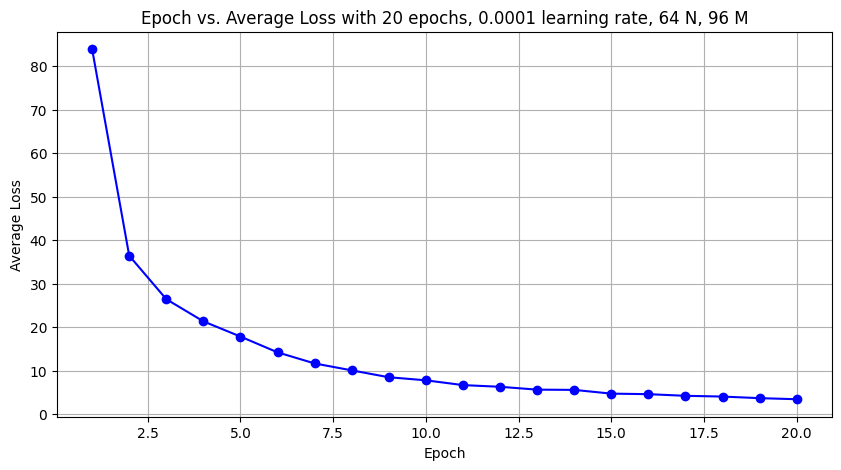

Model with 30 epochs, 0.0001 learning rate, 64 N, 96 M Test epoch 29: Average losses:	Loss: 2.436 |	MSE loss: 0.010 |	PSNR: 20.271 |	SSIM: 0.399



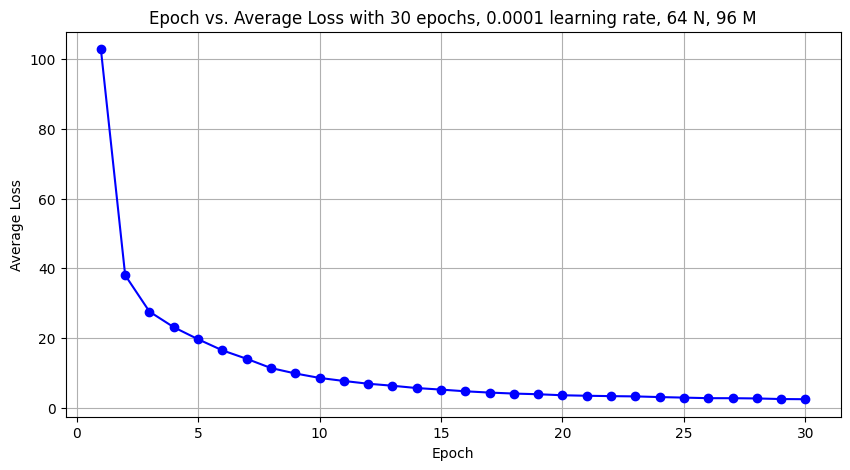

Model with 10 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 9: Average losses:	Loss: 48.080 |	MSE loss: 0.189 |	PSNR: 7.301 |	SSIM: 0.021



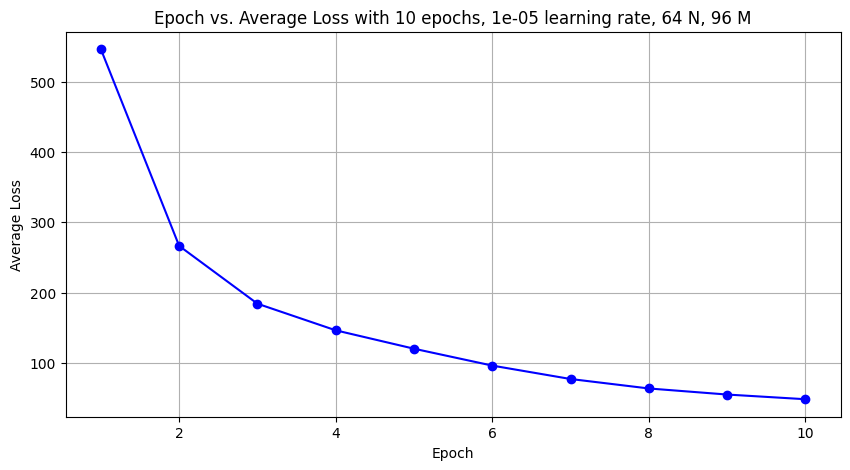

Model with 20 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 19: Average losses:	Loss: 21.024 |	MSE loss: 0.082 |	PSNR: 10.886 |	SSIM: 0.063



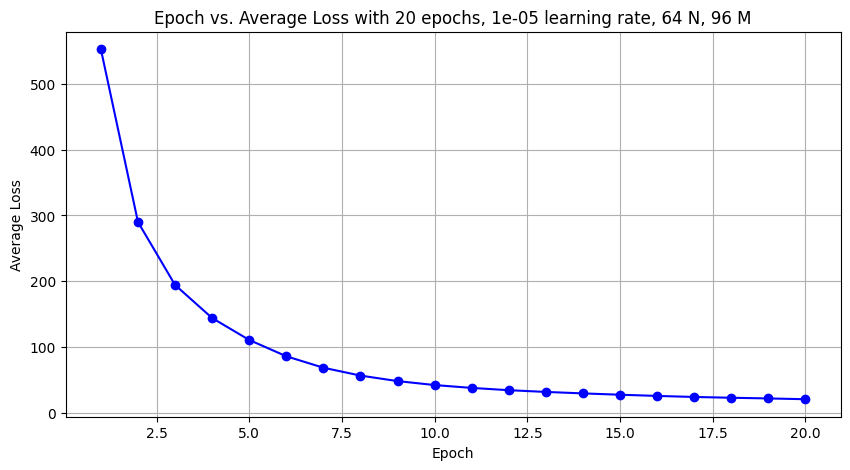

Model with 30 epochs, 1e-05 learning rate, 64 N, 96 M Test epoch 29: Average losses:	Loss: 14.015 |	MSE loss: 0.055 |	PSNR: 12.664 |	SSIM: 0.089



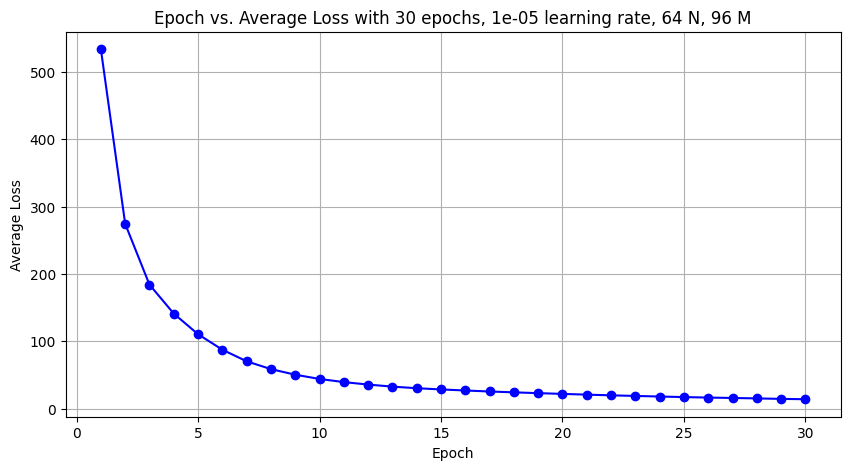

Model with 10 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 9: Average losses:	Loss: 25.977 |	MSE loss: 0.102 |	PSNR: 10.097 |	SSIM: 0.087



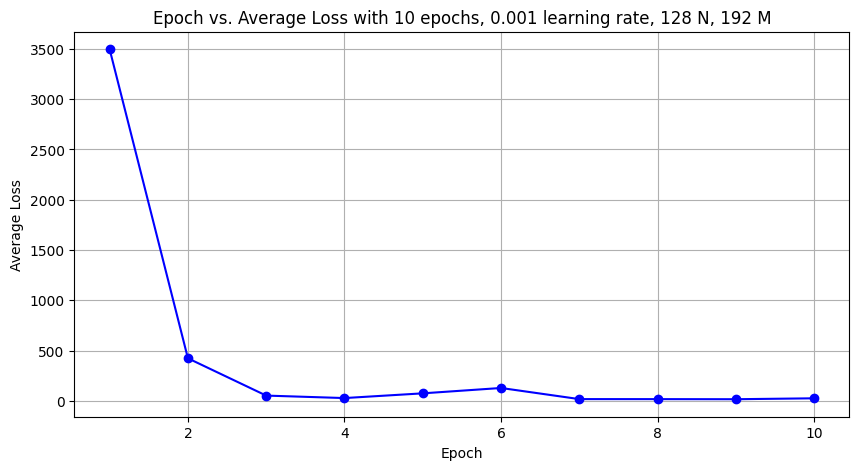

Model with 20 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 19: Average losses:	Loss: 5.931 |	MSE loss: 0.023 |	PSNR: 16.433 |	SSIM: 0.276



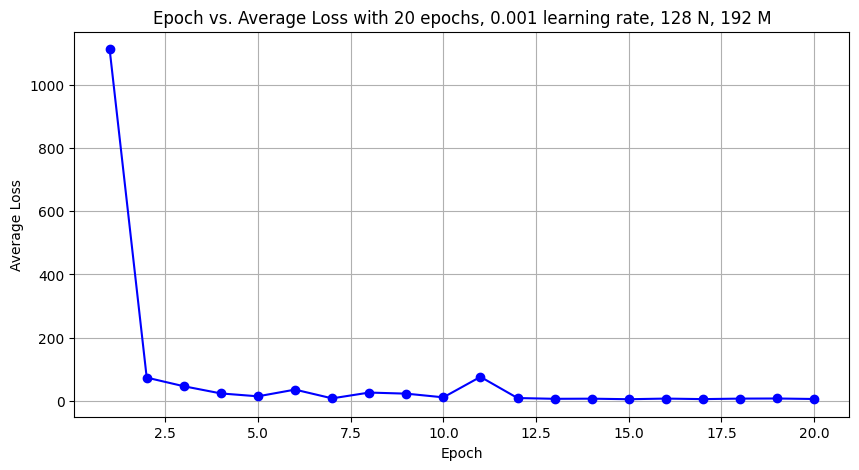

Model with 30 epochs, 0.001 learning rate, 128 N, 192 M Test epoch 29: Average losses:	Loss: 4.230 |	MSE loss: 0.017 |	PSNR: 17.812 |	SSIM: 0.362



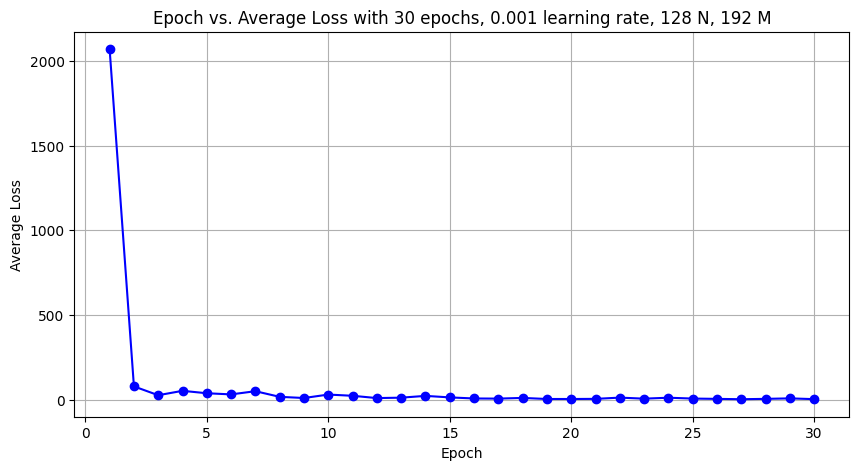

Model with 10 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 9: Average losses:	Loss: 6.453 |	MSE loss: 0.025 |	PSNR: 16.030 |	SSIM: 0.179



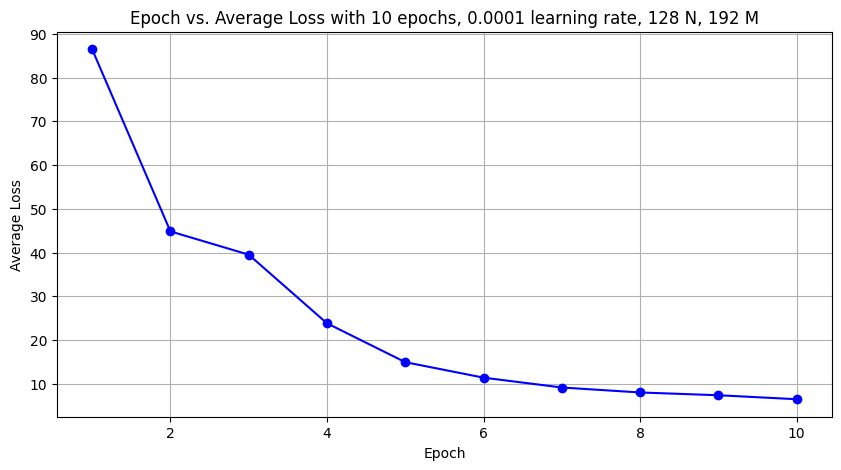

Model with 20 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 19: Average losses:	Loss: 2.839 |	MSE loss: 0.011 |	PSNR: 19.598 |	SSIM: 0.346



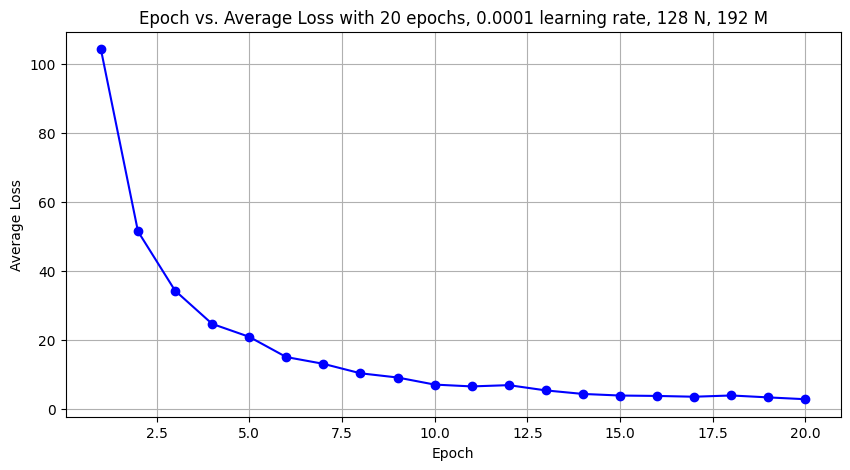

Model with 30 epochs, 0.0001 learning rate, 128 N, 192 M Test epoch 29: Average losses:	Loss: 2.064 |	MSE loss: 0.008 |	PSNR: 20.965 |	SSIM: 0.434



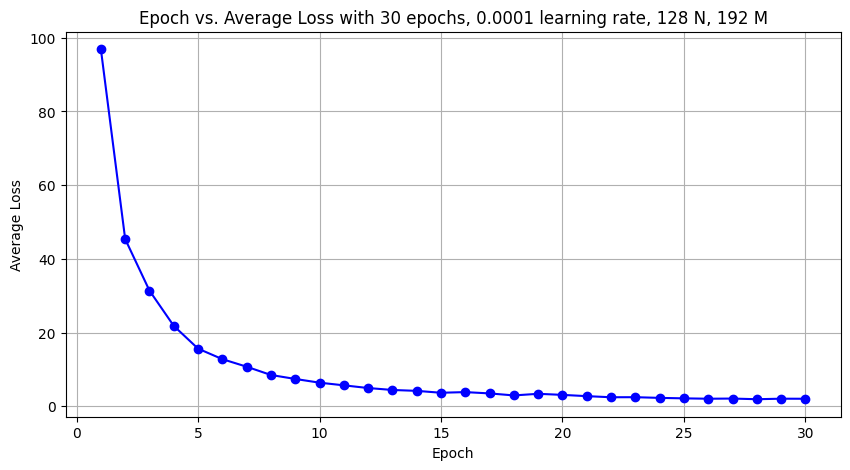

Model with 10 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 9: Average losses:	Loss: 39.157 |	MSE loss: 0.154 |	PSNR: 8.195 |	SSIM: 0.036



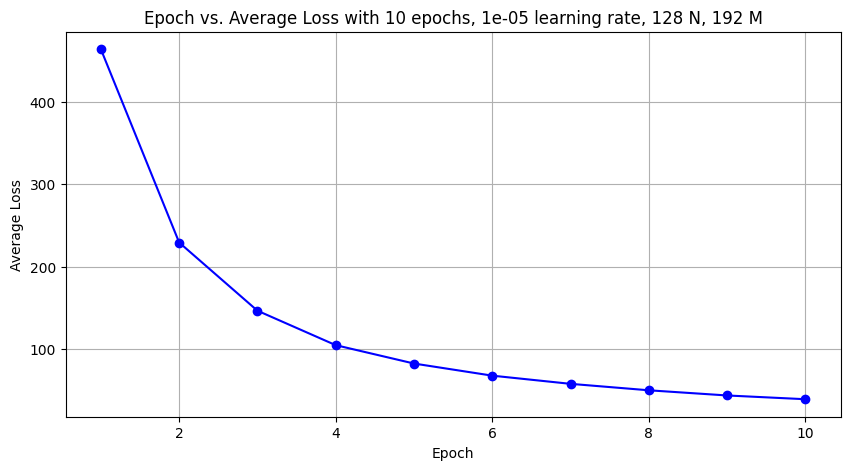

Model with 20 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 19: Average losses:	Loss: 18.375 |	MSE loss: 0.072 |	PSNR: 11.498 |	SSIM: 0.076



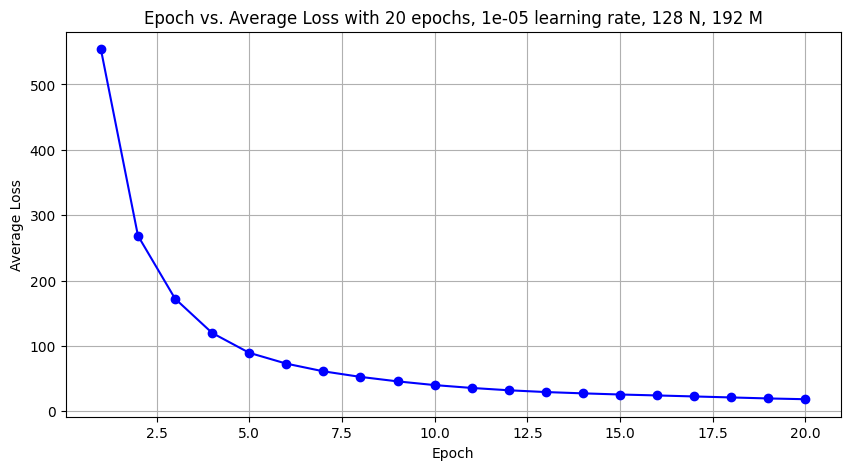

Model with 30 epochs, 1e-05 learning rate, 128 N, 192 M Test epoch 29: Average losses:	Loss: 11.926 |	MSE loss: 0.047 |	PSNR: 13.376 |	SSIM: 0.111



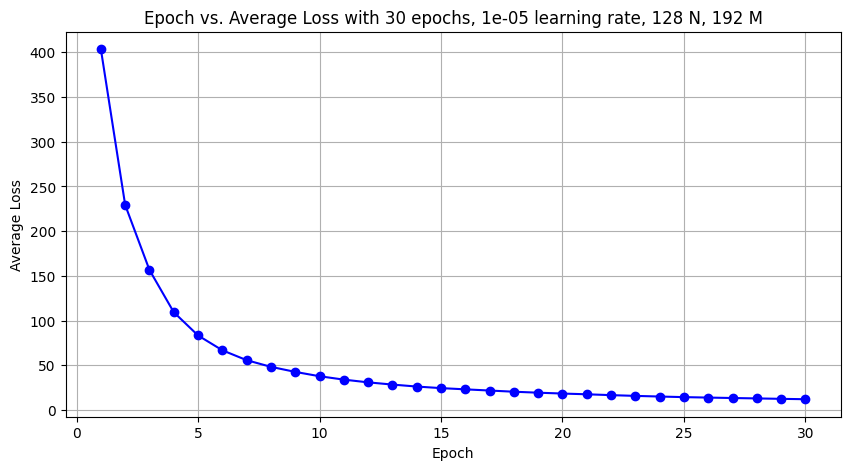

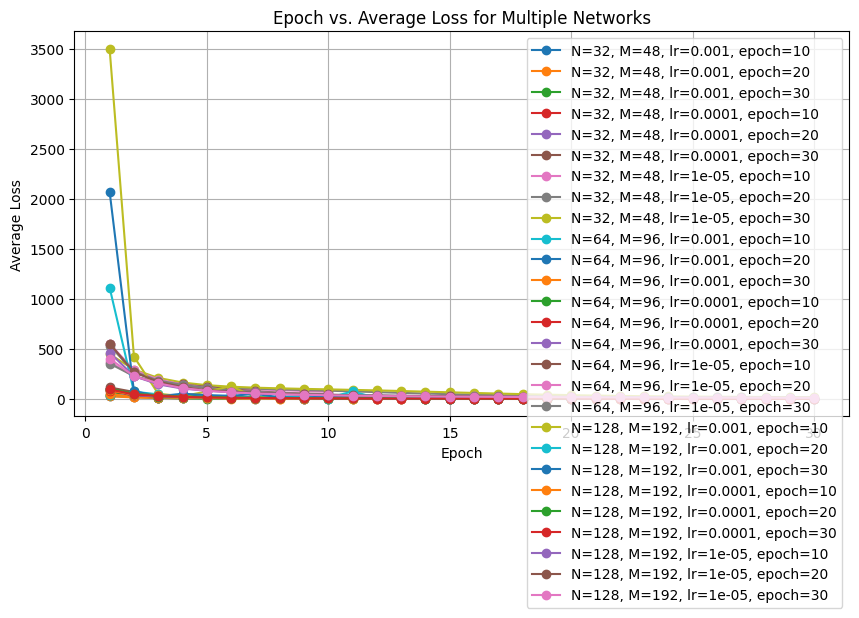

In [ ]:
lr = [1e-3, 1e-4, 1e-5] # learning rate set
epochs = [10, 20, 30] # epochs set
nm = [[32,48], [64,96], [128,192]] # N and M set

class new_net(Network):
    '''
    A new network class inheriting from Network class.
    It also contains its own learning rate, epochs number, value of N and M, and loss in every epoch
    '''
    def __init__(self, N, M, lr, epoch, init_weights=True, **kwargs):
        '''
        Initialize a new network class inheriting from Network class.

        Parameters:
        - N (int): Parameter specific to Network.
        - M (int): Another parameter specific to Network.
        - lr (float): Learning rate for training the network.
        - epoch (int): Number of training epochs.
        - init_weights (bool, optional): If true, initialize weights. Defaults to True.
        - **kwargs: Additional keyword arguments for the base Network class.
        '''
        super().__init__(N, M, **kwargs)  # Initialize the superclass with provided parameters
        self.lr = lr  # Set learning rate
        self.epoch = epoch  # Set number of epochs
        self.N, self.M = N, M  # Store N and M parameters
        self.loss_epoch = []  # Initialize a list to store loss per epoch
        self.test_loss = 0  # Initialize a variable to store the test loss
        self.test_psnr = 0  # Initialize a variable to store the test PSNR
        self.test_ssim = 0  # Initialize a variable to store the test SSIM

    def __str__(self) -> str:
        '''
        Return a string representation of the network's configuration.
        '''
        return f'N: {self.N}, M: {self.M}, lr: {self.lr}, epoch: {self.epoch}'  # Return a formatted string

    def update_loss(self, loss):
        '''
        Update the list of loss per epoch.

        Parameters:
        - loss: Loss value to append to the list.
        '''
        self.loss_epoch.append(loss)  # Append the current loss to the loss_epoch list


def new_test_epoch(epoch, test_dataloader, model, criterion,last_epoch):
    '''
    A same test epoch function. Only create for debugging.
    Only print result if last epoch, in order to save space
    '''
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    mse_loss = AverageMeter()
    psnr = AverageMeter()
    ssim_avg = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            d_out = out_net['x_hat']
            out_criterion = criterion(out_net, d)

            loss.update(out_criterion["loss"])
            mse_loss.update(out_criterion["mse_loss"])
            psnr.update(PSNR(d_out, d))
            ssim_avg.update(ssim(d * 255, d_out * 255, data_range=255, size_average=True))

    if last_epoch:
        print(
            f"Model with {model.epoch} epochs, {model.lr} learning rate, {model.N} N, {model.M} M Test epoch {epoch}: Average losses:"
            f"\tLoss: {loss.avg:.3f} |"
            f"\tMSE loss: {mse_loss.avg:.3f} |"
            f"\tPSNR: {psnr.avg:.3f} |"
            f"\tSSIM: {ssim_avg.avg:.3f}\n"
        )
    model.test_loss = loss.avg
    model.test_psnr = psnr.avg
    model.test_ssim = ssim_avg.avg
    return loss.avg

def train_one_epoch_withoutprint(
    model, criterion, train_dataloader, optimizer, epoch, clip_max_norm
):
    '''
    A training function without print values every time to save space
    '''
    model.train()
    device = next(model.parameters()).device

    for i, d in enumerate(train_dataloader):
        d = d.to(device)

        optimizer.zero_grad()

        out_net = model(d)

        out_criterion = criterion(out_net, d)
        out_criterion["loss"].backward()
        if clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        optimizer.step()

def new_plotloss(newnet):
    '''
    Prepare data for plotting the loss history of a network.

    Parameters:
    - newnet (new_net): A network, which is an object of the `new_net` class.

    This function extracts and prepares the loss history data from the `new_net` instance,
    converting loss values from tensors to numpy arrays for plotting. 
    The result is a list of x-values representing epochs and a list of y-values representing average losses.
    '''

    xs = range(1, newnet.epoch + 1)  # Generate a sequence of epoch numbers from 1 to the total number of epochs

    ys = newnet.loss_epoch  # Retrieve the list of losses stored in the network instance
    y = []  # Initialize an empty list to hold the detached numpy arrays of loss values

    # Convert each tensor in the loss list to a numpy array after detaching it from the computation graph
    for i in ys:
        y.append(i.cpu().detach().numpy())



    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(xs, y, marker='o', linestyle='-', color='b')
    plt.title(f'Epoch vs. Average Loss with {newnet.epoch} epochs, {newnet.lr} learning rate, {newnet.N} N, {newnet.M} M')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()


def new_plotloss_list(nets,numbers=1):
    '''
    Prepare data for plotting the loss history of multiple networks.

    Parameters:
    - nets (list of new_net): A list of networks, each an instance of the `new_net` class.

    This function extracts and prepares the loss history data from each `new_net` instance in the list,
    converting loss values from tensors to numpy arrays for plotting. 
    The result is a set of plots, each representing the average losses across epochs for each network.
    '''
    if numbers == 1:
        plt.figure(figsize=(10, 5))  # Initialize the plot with a specified size

        for newnet in nets:  # Iterate over each network in the list
            xs = range(1, newnet.epoch + 1)  # Generate a sequence of epoch numbers

            ys = newnet.loss_epoch  # Retrieve the list of losses stored in the network instance
            y = []  # Initialize an empty list to hold the detached numpy arrays of loss values

            # Convert each tensor in the loss list to a numpy array after detaching it from the computation graph
            for i in ys:
                y.append(i.cpu().detach().numpy())

            # Plot the loss history for the current network
            plt.plot(xs, y, marker='o', linestyle='-', label=f'N={newnet.N}, M={newnet.M}, lr={newnet.lr}, epoch={newnet.epoch}')

        plt.title('Epoch vs. Average Loss for Multiple Networks')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.legend()  # Add a legend to distinguish different networks
        plt.grid(True)  # Enable grid for better readability
        plt.show()  # Display the plot

    elif numbers > 1:
        num_networks = len(nets)  # Get the number of networks
        num_cols = 3  # Number of columns for subplots
        num_rows = (num_networks + 1) // 2  # Calculate the number of rows needed

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))  # Create subplots

        for i, network_list in enumerate(nets):  # Iterate over each list of networks
            row = i // num_cols
            col = i % num_cols

            for newnet in network_list:  # Iterate over each network in the current list
                xs = range(1, newnet.epoch + 1)  # Generate a sequence of epoch numbers
                ys = newnet.loss_epoch  # Retrieve the list of losses stored in the network instance
                y = [i.cpu().detach().numpy() for i in ys]  # Convert tensor to numpy array

                # Plot the loss history for the current network on the corresponding subplot
                axs[row, col].plot(xs, y, marker='o', linestyle='-', label=f'N={newnet.N}, M={newnet.M}, lr={newnet.lr}, epoch={newnet.epoch}')

            axs[row, col].set_title(f'Networks {i+1}-{i+len(network_list)}')  # Set subplot title
            axs[row, col].set_xlabel('Epoch')
            axs[row, col].set_ylabel('Average Loss')
            axs[row, col].legend()  # Add legend to subplot
            axs[row, col].grid(True)  # Enable grid for better readability

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()  # Display the plot


# import csv

def export_nets_to_csv(nets, filename):
    '''
    Export the attributes of multiple new_net instances to a CSV file.

    Parameters:
    - nets (list of new_net): A list of new_net instances.
    - filename (str): The name of the CSV file to which the data will be written.

    Each row in the CSV file will include the index, number of epochs, learning rate,
    N, M, average loss, PSNR, and SSIM of each network.
    '''

    # Open a file to write
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the header row
        writer.writerow(['Index', 'Epochs', 'Learning Rate', 'N', 'M', 'Average Loss', 'PSNR', 'SSIM'])

        # Write the data rows
        for index, net in enumerate(nets):
            # Extract the required attributes from each network
            epochs = net.epoch
            learning_rate = net.lr
            N = net.N
            M = net.M
            # Assuming average loss, PSNR, and SSIM are calculated and stored in attributes
            average_loss = net.average_loss
            PSNR = net.PSNR
            SSIM = net.SSIM

            # Write the row to the CSV file
            writer.writerow([index, epochs, learning_rate, N, M, average_loss, PSNR, SSIM])



# Initialize a list to hold instances of new_net (all networks which needs to be tested)
nets = []

i = 0
# Create networks with various configurations
while i < 3:  # Outer loop over a dimension, 'i'
    j = 0
    while j < 3:  # Middle loop over a dimension, 'j'
        k = 0
        while k < 3:  # Inner loop over a dimension, 'k'
            # Create a new network instance with parameters from nm, lr, and epochs arrays
            net = new_net(nm[i][0], nm[i][1], lr[j], epochs[k]).to(device)
            nets.append(net)  # Add the newly created network to the list
            k += 1  # Increment the innermost loop variable
        j += 1  # Increment the middle loop variable
    i += 1  # Increment the outer loop variable




# Iterate over each network in the 'nets' list
for net in nets:
    # Configure the optimizer for the current network using its learning rate
    optimizer = configure_optimizers(net, net.lr)
    # Setup a learning rate scheduler that reduces the learning rate when a metric stops improving
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")

    # Iterate over each epoch up to the total number of epochs specified in the network
    for epoch in range(0, net.epoch):
        # Train the network for one epoch without printing any outputs
        train_one_epoch_withoutprint(
            net,
            criterion,
            train_dataloader,
            optimizer,
            epoch,
            clip_max_norm,
        )
        # Evaluate the network at the end of the epoch and optionally print the evaluation if it's the last epoch
        loss = new_test_epoch(epoch, test_dataloader, net, criterion, epoch == net.epoch-1)
        # Append the evaluated loss to the network's loss history
        net.loss_epoch.append(loss)
        # Step the learning rate scheduler with the latest loss
        lr_scheduler.step(loss)

        # Determine if the current loss is the best (lowest) and update best_loss accordingly
        is_best = loss < best_loss
        best_loss = min(loss, best_loss)
    # After completing all epochs, plot the loss history of the network
    new_plotloss(net)

# Plot the loss history of all networks in the 'nets' list
new_plotloss_list(nets)







    



    


In [34]:
def new_plotloss_list(nets,numbers=1):
    '''
    Prepare data for plotting the loss history of multiple networks.

    Parameters:
    - nets (list of new_net): A list of networks, each an instance of the `new_net` class.

    This function extracts and prepares the loss history data from each `new_net` instance in the list,
    converting loss values from tensors to numpy arrays for plotting. 
    The result is a set of plots, each representing the average losses across epochs for each network.
    '''
    if numbers == 1:
        plt.figure(figsize=(10, 5))  # Initialize the plot with a specified size

        for newnet in nets:  # Iterate over each network in the list
            xs = range(1, newnet.epoch + 1)  # Generate a sequence of epoch numbers

            ys = newnet.loss_epoch  # Retrieve the list of losses stored in the network instance
            y = []  # Initialize an empty list to hold the detached numpy arrays of loss values

            # Convert each tensor in the loss list to a numpy array after detaching it from the computation graph
            for i in ys:
                y.append(i.cpu().detach().numpy())

            # Plot the loss history for the current network
            plt.plot(xs, y, marker='o', linestyle='-', label=f'N={newnet.N}, M={newnet.M}, lr={newnet.lr}, epoch={newnet.epoch}')

        plt.title('Epoch vs. Average Loss for Multiple Networks')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.legend()  # Add a legend to distinguish different networks
        plt.grid(True)  # Enable grid for better readability
        plt.show()  # Display the plot

    elif numbers > 1:
        num_networks = len(nets)  # Get the number of networks
        num_cols = 3  # Number of columns for subplots
        num_rows = (num_networks + 1) // 3  # Calculate the number of rows needed

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))  # Create subplots

        for i, network_list in enumerate(nets):  # Iterate over each list of networks
            row = i // num_cols
            col = i % num_cols

            for newnet in network_list:  # Iterate over each network in the current list
                xs = range(1, newnet.epoch + 1)  # Generate a sequence of epoch numbers
                ys = newnet.loss_epoch  # Retrieve the list of losses stored in the network instance
                y = [i.cpu().detach().numpy() for i in ys]  # Convert tensor to numpy array

                # Plot the loss history for the current network on the corresponding subplot
                axs[row, col].plot(xs, y, marker='o', linestyle='-', label=f'N={newnet.N}, M={newnet.M}, lr={newnet.lr}, epoch={newnet.epoch}')

            axs[row, col].set_title(f'Networks {i+1}-{i+len(network_list)}')  # Set subplot title
            axs[row, col].set_xlabel('Epoch')
            axs[row, col].set_ylabel('Average Loss')
            axs[row, col].legend()  # Add legend to subplot
            axs[row, col].grid(True)  # Enable grid for better readability

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()  # Display the plot

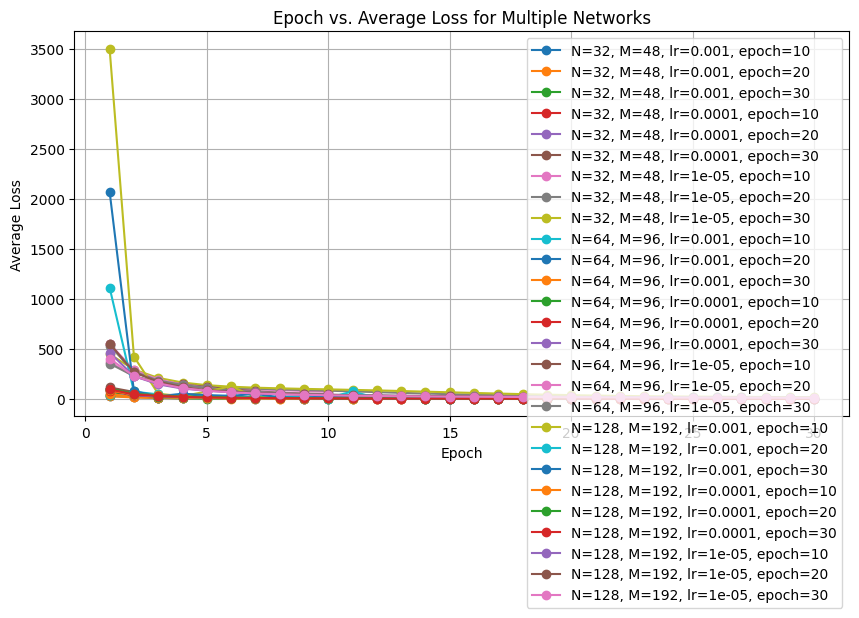

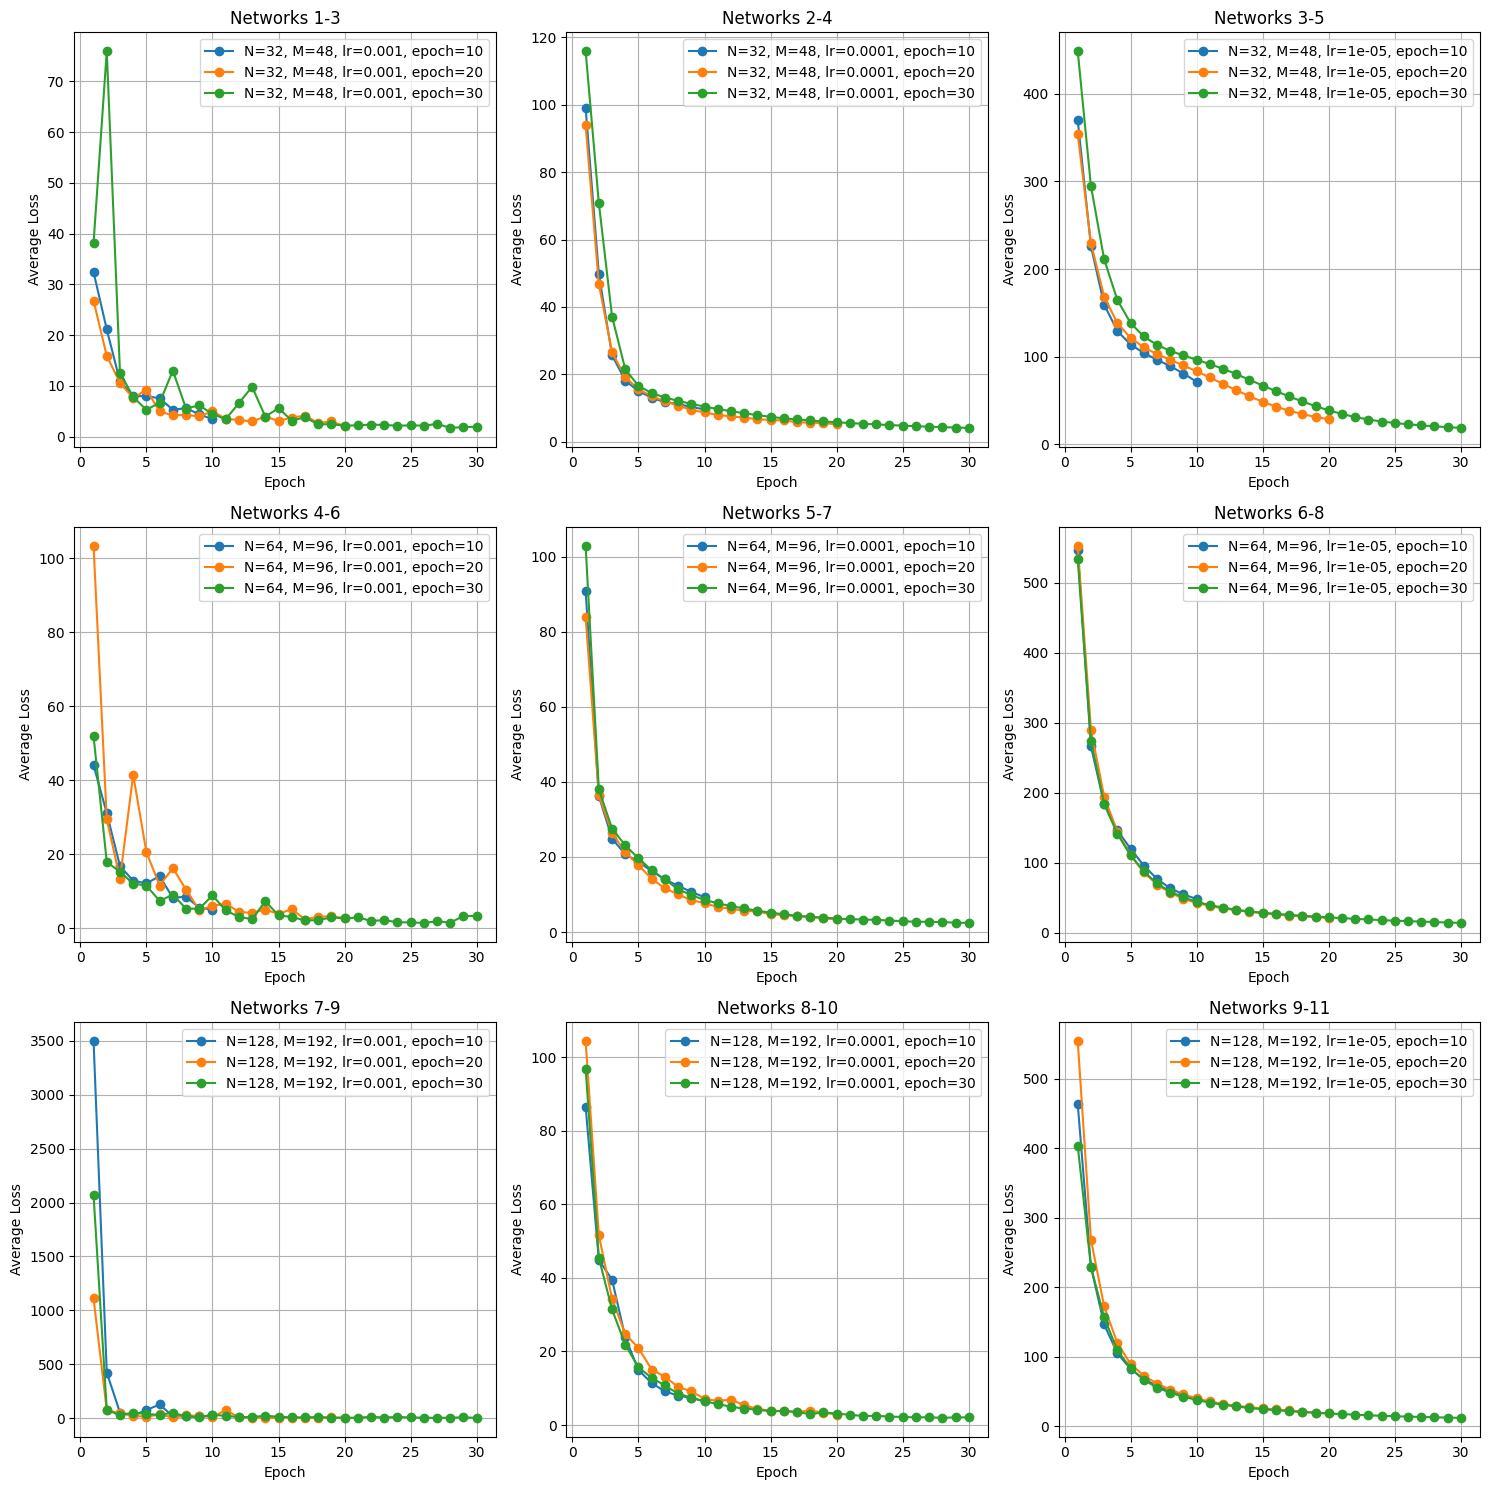

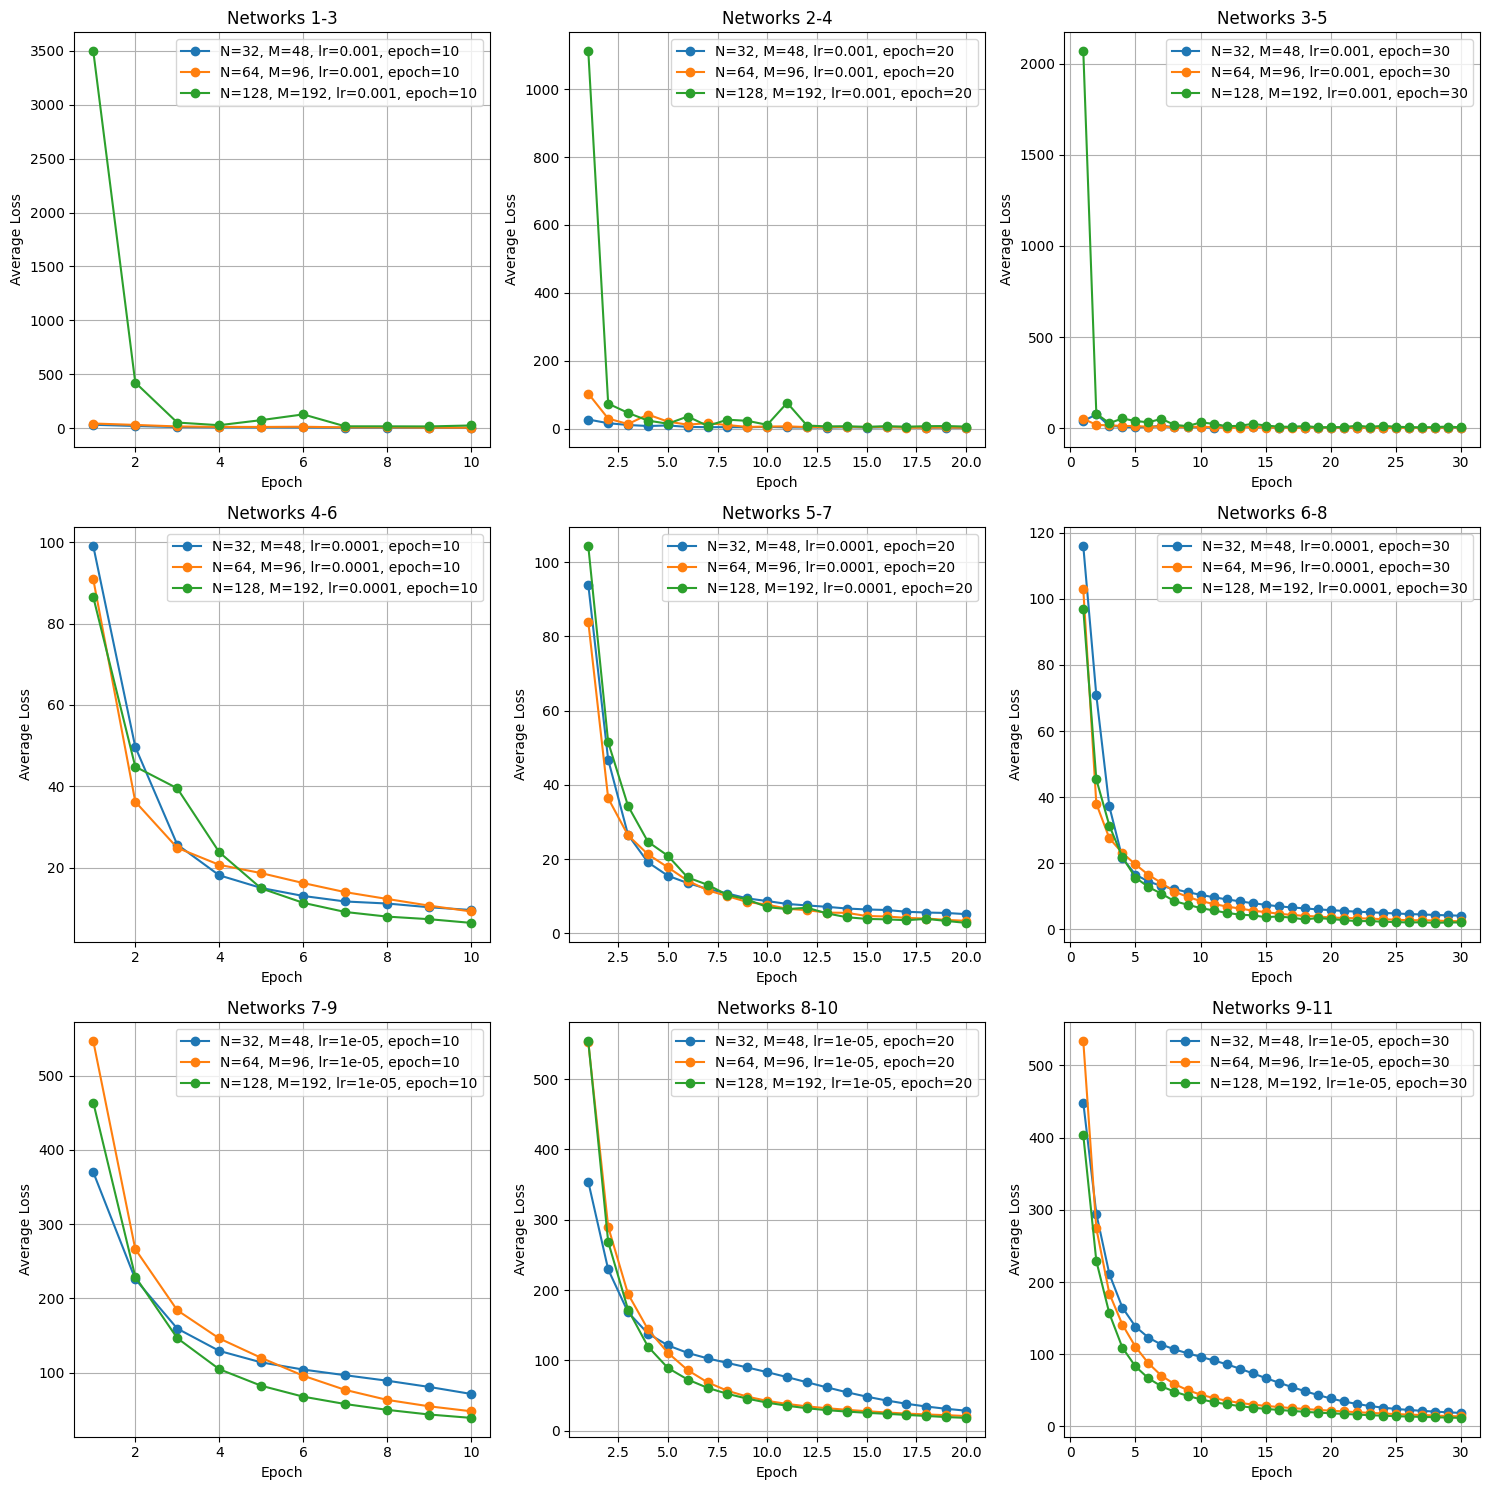

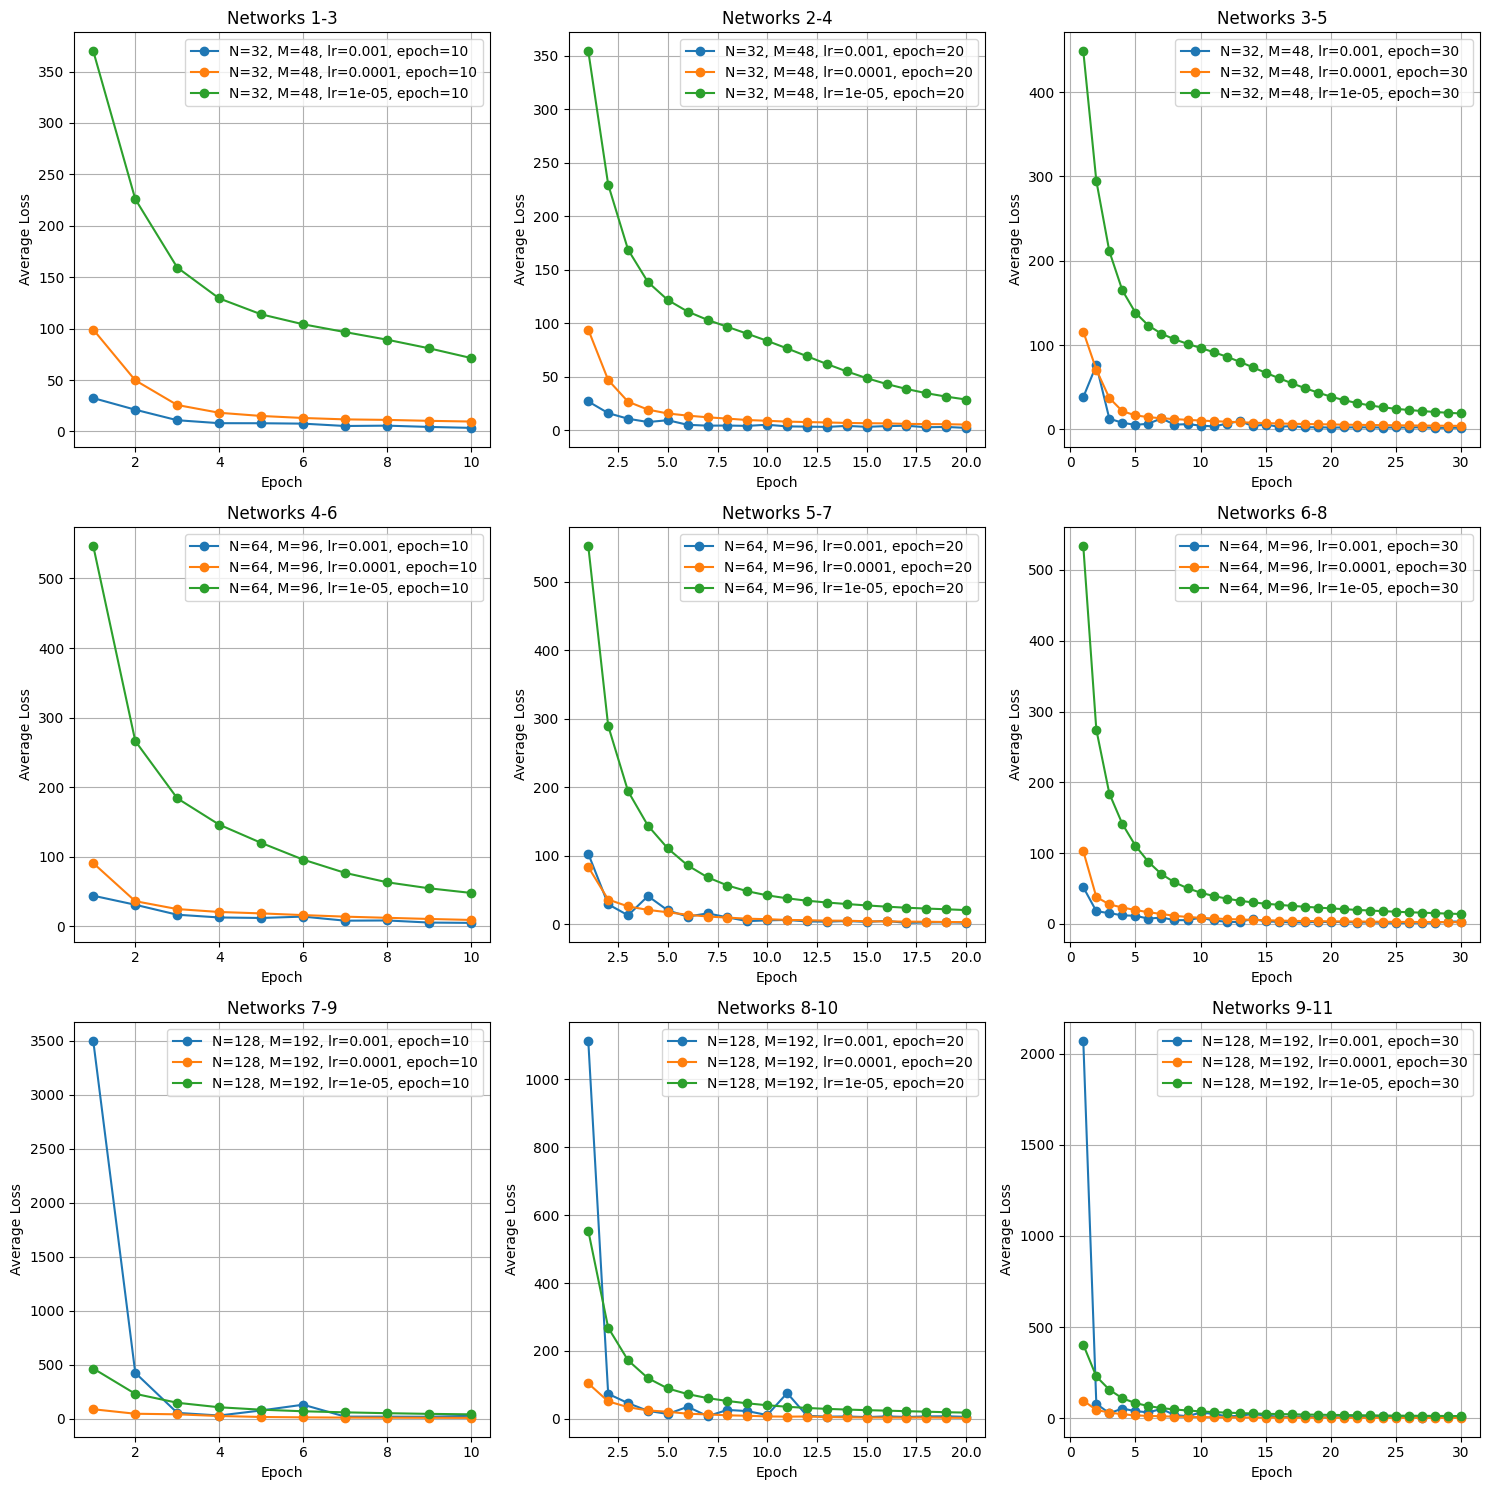

In [35]:
# Plot the loss history of all networks in the 'nets' list
new_plotloss_list(nets)
lr = [1e-3, 1e-4, 1e-5] # learning rate set
epochs = [10, 20, 30] # epochs set
nm = [[32,48], [64,96], [128,192]] # N and M set
# plot for different epoch
def group_networks(nets):
    lr_nm_same = []
    lr_epoch_same = []
    epoch_nm_same = []

    for net in nets:
        # Same learning rate & (N, M) networks
        lr_nm_matches = [x for x in lr_nm_same if x[0].lr == net.lr and x[0].N == net.N and x[0].M == net.M]
        if not lr_nm_matches:
            lr_nm_matches.append([])
            lr_nm_same.append(lr_nm_matches[0])
        lr_nm_matches[0].append(net)

        # Same learning rate & epochs networks
        lr_epoch_matches = [x for x in lr_epoch_same if x[0].lr == net.lr and x[0].epoch == net.epoch]
        if not lr_epoch_matches:
            lr_epoch_matches.append([])
            lr_epoch_same.append(lr_epoch_matches[0])
        lr_epoch_matches[0].append(net)

        # Same learning rate & epochs networks
        epoch_nm_matches = [x for x in epoch_nm_same if x[0].epoch == net.epoch and x[0].N == net.N and x[0].M == net.M]
        if not epoch_nm_matches:
            epoch_nm_matches.append([])
            epoch_nm_same.append(epoch_nm_matches[0])
        epoch_nm_matches[0].append(net)

    return lr_nm_same, lr_epoch_same, epoch_nm_same

lr_nm_same, lr_epoch_same, epoch_nm_same = group_networks(nets)

new_plotloss_list(lr_nm_same, numbers=len(lr_nm_same))
new_plotloss_list(lr_epoch_same, numbers=len(lr_epoch_same))
new_plotloss_list(epoch_nm_same, numbers=len(epoch_nm_same))



# Export the data of all networks to a CSV file
# export_nets_to_csv(nets, 'network_data.csv')

## 1.5 Quantization

In [29]:
# ###################################################
# a baseline model

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Quan_Network(nn.Module):
    '''
    A neural network that integrates quantization between the encoding (g_a) and decoding (g_s) stages. 
    This network is designed for tasks such as image compression where quantization can reduce the 
    amount of data required to represent an image.

    Parameters:
    - N (int): Number of channels in the intermediate layers of the encoder.
    - M (int): Number of channels in the output layer of the encoder.
    - init_weights (bool, optional): Flag to determine whether to initialize weights upon creation. Defaults to True.
    - **kwargs: Additional keyword arguments for the superclass.
    '''

    def __init__(self, N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)
        # Define the encoder part
        self.g_a = nn.Sequential(
            conv(3, N),
            conv(N, N),
            conv(N, N),
            conv(N, M),
        )
        # Define the decoder part
        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            deconv(N, N),
            deconv(N, 3),
        )
        self.N = N
        self.M = M
        # Initialize weights if required
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        '''
        Defines the computation performed at every call of the network.
        '''
        y = self.g_a(x)
        x_hat = self.g_s(y)
        return {"x_hat": x_hat}

    def _initialize_weights(self):
        '''
        Initialize weights of the convolutional and transpose convolutional layers using He initialization.
        '''
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        '''
        Compress the input using the encoder and quantize the output.
        '''
        y = self.g_a(x)
        quantized, self.max_val, self.min_val = self.quantize(y)
        return quantized

    def decompress(self, quantized):
        '''
        Decompress the quantized data using the decoder.
        '''
        y_hat = self.dequantize(quantized, self.max_val, self.min_val)
        x_hat = self.g_s(y_hat).clamp_(0, 1)
        return {"x_hat": x_hat}
    
    def quantize(self, y, levels=256):
        '''
        Quantize the encoder output to reduce data size for storage or transmission.
        '''
        max_val = y.max()
        min_val = y.min()
        quantized = torch.floor((y - min_val) / (max_val - min_val) * (levels - 1))
        return quantized, max_val, min_val

    def dequantize(self, quantized, max_val, min_val, levels=256):
        '''
        Reconstruct the original data from its quantized form.
        '''
        y_hat = quantized * (max_val - min_val) / (levels - 1) + min_val
        return y_hat






compression ratio: compressed/original 0.252014652014652


Text(0.5, 1.0, 'decompressed')

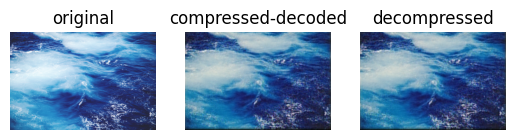

In [30]:

net = Quan_Network(128,192) # define a quantization network. Parameters are from the best performance network from 1.4
net = net.to(device)
import random
dataset = '/kaggle/input/imageset' # Modify this if you change the path
test_dataset = ImageFolder(dataset, split="valid", transform=transforms.ToTensor())
image = test_dataset[random.randint(0,10)].unsqueeze(0).to(device) # randomly choose a test image
net.load_state_dict(torch.load('checkpoint_best_loss.pth.tar', map_location=device)["state_dict"])
predicted = net(image)['x_hat'].squeeze(0).detach()
compressed = net.compress(image) # compress and quantize the image
decompressed = net.decompress(compressed)['x_hat'][0].detach() # dequantize and decompress the image, then convert to a numpy array which can be plotted

print('compression ratio: compressed/original {}'.format(compressed.numel() / image.numel())) # calculate compression ratio
fig, axes = plt.subplots(1,3)
axes[0].imshow(image.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')
axes[2].imshow(decompressed.cpu().permute(1, 2, 0))
axes[2].axis('off')
axes[2].set_title('decompressed')






training on cuda
Learning rate: 0.0001
Train epoch 0: [0/250 (0%)]	Loss: 5.309 |	MSE loss: 0.021
Train epoch 0: [160/250 (62%)]	Loss: 10.557 |	MSE loss: 0.041
Test epoch 0: Average losses:	Loss: 9.758 |	MSE loss: 0.038 |	PSNR: 14.246 |	SSIM: 0.110

Learning rate: 0.0001
Train epoch 1: [0/250 (0%)]	Loss: 8.813 |	MSE loss: 0.035
Train epoch 1: [160/250 (62%)]	Loss: 5.186 |	MSE loss: 0.020
Test epoch 1: Average losses:	Loss: 5.850 |	MSE loss: 0.023 |	PSNR: 16.465 |	SSIM: 0.169

Learning rate: 0.0001
Train epoch 2: [0/250 (0%)]	Loss: 6.529 |	MSE loss: 0.026
Train epoch 2: [160/250 (62%)]	Loss: 3.919 |	MSE loss: 0.015
Test epoch 2: Average losses:	Loss: 4.618 |	MSE loss: 0.018 |	PSNR: 17.491 |	SSIM: 0.214

Learning rate: 0.0001
Train epoch 3: [0/250 (0%)]	Loss: 2.434 |	MSE loss: 0.010
Train epoch 3: [160/250 (62%)]	Loss: 3.576 |	MSE loss: 0.014
Test epoch 3: Average losses:	Loss: 4.431 |	MSE loss: 0.017 |	PSNR: 17.673 |	SSIM: 0.223

Learning rate: 0.0001
Train epoch 4: [0/250 (0%)]	Loss: 4.

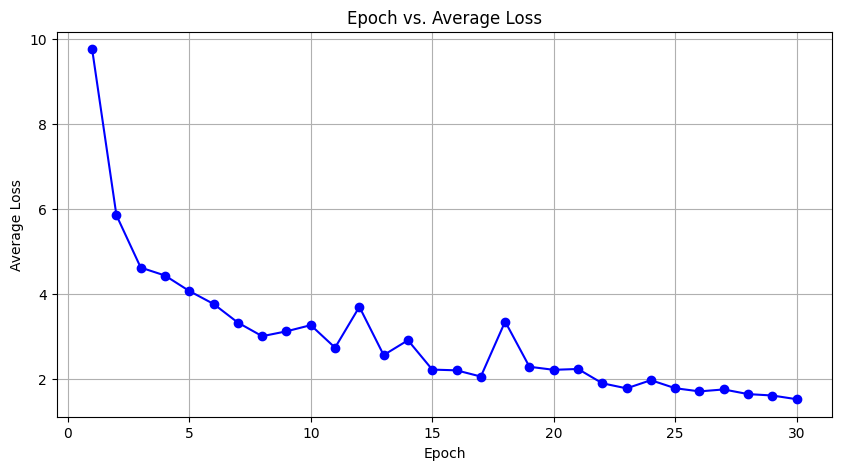

finished training in 699 seconds


In [31]:

print("training on", device)
optimizer = configure_optimizers(net, 1e-4) # also this learning rate performs best
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

last_epoch = 0


loss_epoch = list()
start = time.time()
for epoch in range(last_epoch, 30): # training for 30 epochs will have best output
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    train_one_epoch(
        net,
        criterion,
        train_dataloader,
        optimizer,
        epoch,
        clip_max_norm,
    )
    loss = test_epoch(epoch, test_dataloader, net, criterion)
    loss_epoch.append(loss)
    lr_scheduler.step(loss)

    is_best = loss < best_loss
    best_loss = min(loss, best_loss)

plotloss(30,loss_epoch)


print(f"finished training in {round(time.time()-start)} seconds")

compression ratio: compressed/original 0.25098039215686274


Text(0.5, 1.0, 'decompressed')

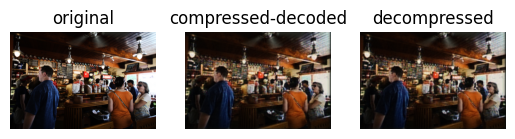

In [ ]:
dataset = '/kaggle/input/imageset' # Modify this if you change the path
test_dataset = ImageFolder(dataset, split="valid", transform=transforms.ToTensor())
image = test_dataset[random.randint(10,20)].unsqueeze(0).to(device) # randomly choose a test image
net.load_state_dict(torch.load('checkpoint_best_loss.pth.tar', map_location=device)["state_dict"])
predicted = net(image)['x_hat'].squeeze(0).detach()
pred = net.compress(image)
decompressed = net.decompress(pred)['x_hat'][0].detach() # dequantize and decompress the image, then convert to a numpy array which can be plotted
print('compression ratio: compressed/original {}'.format(pred.numel() / image.numel())) # calculate compression ratio

fig, axes = plt.subplots(1,3)
axes[0].imshow(image.squeeze(0).cpu().permute(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('original')
axes[1].imshow(predicted.cpu().permute(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('compressed-decoded')
axes[2].imshow(decompressed.cpu().permute(1, 2, 0))
axes[2].axis('off')
axes[2].set_title('decompressed')
